# **Singular Value Decomposition** #

### **Background:** ###

The SVD is the unique matrix decomposition of $X \in \mathbb{C}^{n \times m}$ given by 
$$ X = U \Sigma V^*$$ 
where $U \in U(n)$, $V\in U(m)$ and $\Sigma = \text{diag}(\sigma_1 \cdots, \sigma_m) \in \mathbb{C}^{n\times m}$.
In order for uniqueness to hold, one must take the diagonal entires of $\Sigma$ to be in non-increasing order. For rank-deficient matrices of the form $n \ge m$, one can write
$$ X = U\Sigma V^* = \begin{bmatrix} \hat U &  \hat U^{\perp} \end{bmatrix} \begin{bmatrix} \hat \Sigma \\ 0 \end{bmatrix} V^* = \hat U \hat \Sigma V^*,$$ 
where $\hat \Sigma \in \mathbb{C}^{m\times m}$. This later form is known as the *economy SVD*. 

Since $\Sigma$ is diagonal, we have that $$X = U(V\Sigma)^* = \sum_{k\in [m]} \sigma_k u_k v_k^*$$
is the sum of rank-one matrices. For a fixed rank $r< m$, we define
$$\tilde X = \sum_{k\in [r]}\sigma_k u_kv_k^* = \tilde U\tilde \Sigma \tilde V^*,$$ 
where $\tilde U, \tilde V$ are the first $r$ columns of $U,V$ and $\tilde \Sigma$ is the upper $r\times r$ sub-block of $\Sigma$. 
This is the best rank-$r$ approximation of $X$ in both the Frobenius and spectral (operator) norm, and in particular, we have
$$ \Vert X - \tilde X\Vert_{F}^2 = \sum_{k= r+1}^m \sigma_k^2 \hspace{0.2cm}\text{ and }\hspace{0.2cm}\Vert X - \tilde{X} \Vert_{2} = \sigma_{r+1}.$$


### **Computing the SVD** ###

In [1]:
import numpy as np

# The full and economy SVDs 
n,m = 10,8                                          # Set matrix size 
X = np.random.rand(n,m)                             # Create random data matrix
U, S, Vt = np.linalg.svd(X, full_matrices=True)     # Full matrix SVD 
Uh, Sh, Vth = np.linalg.svd(X,full_matrices=False)  # Economy SVD

# Note: S is returned as vector of non-zero singular values, and Vt is the transpose of the right singular vectors V.

# The truncated SVD
r = len(S)-1 if len(S)>1 else len(S)                # Take the rank to be one less than X
Xapprox = U[:, :r] @ np.diag(S)[:r, :r] @ Vth[:r, :]

check_err = False 

if check_err:
    fro_err  =  np.linalg.norm(X-Xapprox, 'fro') - np.sqrt(np.sum(S[r:]**2)) # Frobenius norm error of rank r approx minus square sum of remaining sing vals 
    spec_err = np.linalg.norm(X - Xapprox, 2) - S[r]                         # Spectral norm error or rank r approx minus next sing value 
    econ_sup_err = np.max(X - (Uh @ np.diag(S) @ Vth))                       # sup norm of X minus economy SVD
    print(fro_err, spec_err, econ_sup_err)

### **Image Compression with SVD** ###

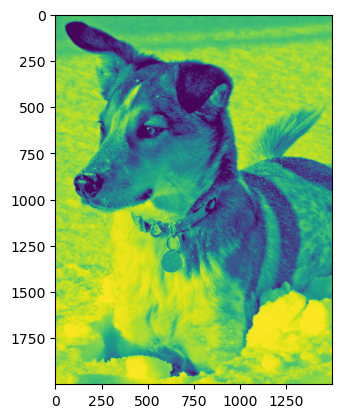

In [43]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os

# Load image to be compressed
img_colored = imread(os.path.join('..','..','DATA','dog.jpg'))

# Convert Image from RGB to Grayscale Data Matrix 
X = np.mean(img_colored, -1)  # Note: img_colored.shape = (2000, 1500,3), where the last is RBG triple. We take mean along this axis. 

# Show grayscale image 
img = plt.imshow(X)

# Take the economy SVD

U,S_vals, Vt = np.linalg.svd(X, full_matrices=False)
S = np.diag(S_vals)


Text(0.5, 1.0, "Note: 80$\\%$ of the 'energy` is contained in the first 100 singular values")

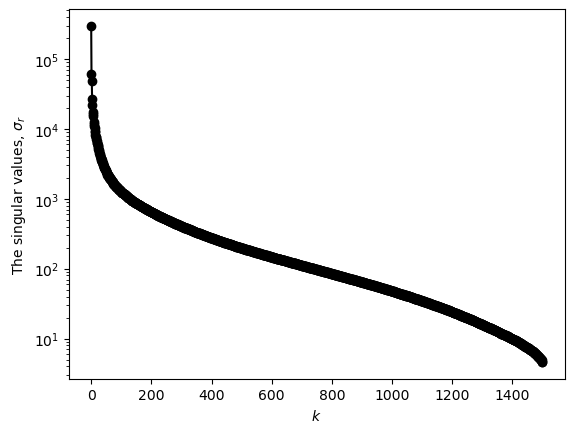

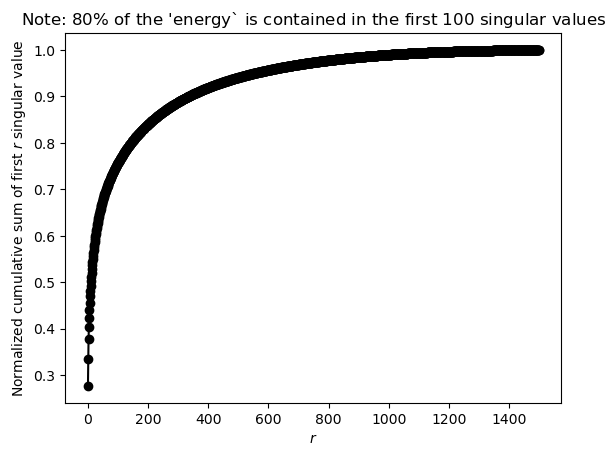

In [53]:
# Plot the Singular Values and the Cumulative sum of the singular values


plt.figure(1)
plt.semilogy(range(0,len(S_vals)), S_vals, "o-", color = 'black')
plt.ylabel("The singular values, $\sigma_r$")
plt.xlabel("$k$")


plt.figure(2)
plt.plot(np.cumsum(S_vals)/ np.sum(S_vals), 'o-', color = 'black')
plt.ylabel("Normalized cumulative sum of first $r$ singular value")
plt.xlabel('$r$')
plt.title("Note: 80$\%$ of the 'energy` is contained in the first 100 singular values")


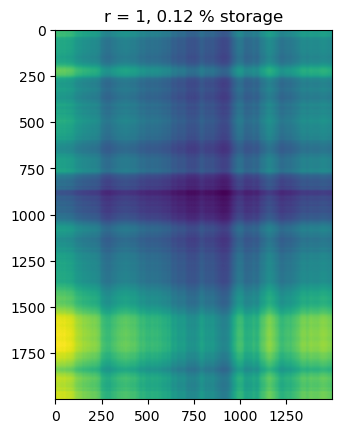

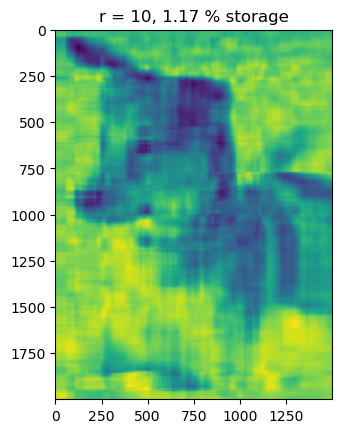

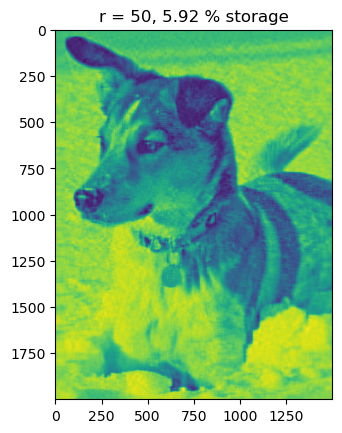

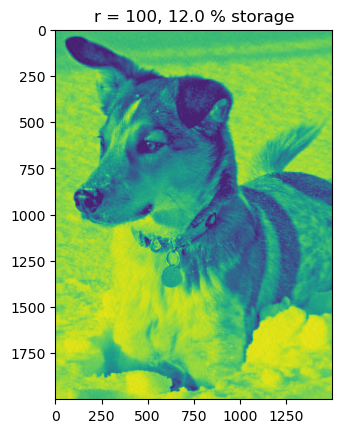

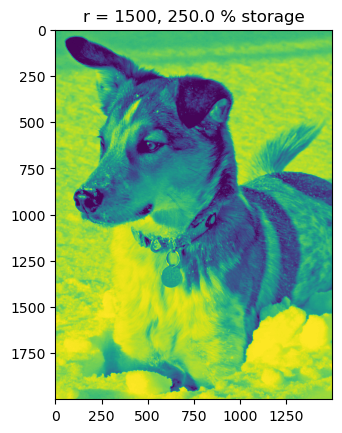

In [72]:
# Approximate the image with truncated SVD for various ranks, r

full_storage = 2000*1500         # number of pixels in original image 
ranks = [1,10,50,100,1500]       # compressed storage ranks to compute 
for r in ranks:
    # Compute reduced Image
    Xapprox = U[:, :r] @ S[:r, :r] @ Vt[:r, :]
    img = plt.imshow(Xapprox)
    # Compute storage (now shared over the three matrices)
    compressed_storage = (2000* r)+(r*r)+(r*1500)
    percent_storage = round(compressed_storage/full_storage * 100, 2)
    title_str = "r = {}, {} % storage".format(r, percent_storage)
    plt.title(title_str)
    plt.show()


### **Linear Regression** ###

Given $A\in \mathbb{C}^{n\times m}$ and $b \in \mathbb{C}^n$, we seek $\tilde{x}\in \mathbb{C}^m$ such that
$$\tilde{x} \in \argmin \Vert Ax - b \Vert_2.$$
The system of equations $Ax = b$ is called *under-determined* if $n < m$, in which case there are (in general) infinitely many solutions, and we seek
$$\tilde{x} \in \argmin  \Vert x \Vert_2 \text{ subject to } A x = b.$$
If $n > m$, then the problem is *over-determined*, and (in general) no solutions exist, and the least-squares solution above is the 2-norm best approximate. The following returns either solution.

Let $A = U\Sigma V^*$ have the exact truncated SVD $A = \tilde U \tilde \Sigma \tilde V^*$, and denote the *left pseudo-inverse* of $A$ by
$$A^\dagger = \tilde V \tilde \Sigma ^{-1}\tilde U^*$$
Note that 
$$A^\dagger A = \tilde V\tilde V^* = I_{m\times m},$$
but this pseudo-inverse is only a true left inverse provided that the truncated SVD captures all of the non-zero singular values. In general, for a non-exact truncation, it merely approximates the identity. We set
$$\tilde x = A^{\dagger}B = \tilde V\tilde \Sigma^{-1}\tilde U^* b$$
Then
$$A\tilde x = (\tilde U \tilde \Sigma \tilde V^*)(\tilde V\tilde \Sigma^{-1}\tilde U^* b) = \tilde U\tilde U^*b = \text{Proj}_{\text{Col}(\tilde U)}b = \text{Proj}_{\text{Col}(A)}b$$

Thus, if $b\in \text{Col}(A)$, then $\tilde x$ satisfies $Ax=b$. Otherwise, $\tilde x$ is as good as it gets!


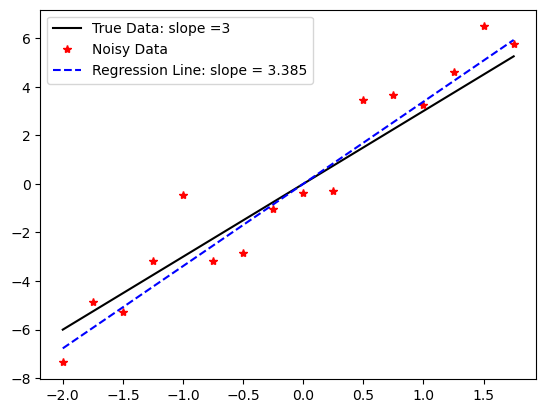

In [126]:
#### One dimensional least squares fit to noisy data:

# Generate data: 

x = 3                           # true slope
A = np.arange(-2,2,0.25)        # numpy line space [-2,2) in 0.25
A = a.reshape(-1,1)             # reshape as column vector

true_data = A*x
noise = np.random.randn(A.shape[0], A.shape[1])     #gaussian random noise
noisy_data = true_data + noise 

# Compute Regression
U,S,VT = np.linalg.svd(A, full_matrices = False)
x_tilde = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ noisy_data

approx_data = A*x_tilde

#Plot Regression
plt.figure()
plt.plot(A, true_data, color = 'k', label = 'True Data: slope ={}'.format(x))
plt.plot(A, noisy_data, 'r*', label = 'Noisy Data')
plt.plot(A, approx_data, 'b--', label='Regression Line: slope = {}'.format(round(x_tilde[0][0],3)) )
plt.legend()
plt.show()


### **Principal Component Analysis (PCA)**

Some background...